In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os,cv2
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv2D, MaxPooling2D,Dense, Dropout,Rescaling, Flatten
from sklearn.metrics import confusion_matrix

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
base_dir = '/content/drive/My Drive/Capstone Project/dataset'

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
labels=[]
for folder in os.listdir(base_dir):
    labels.append(folder)
labels.sort()
labels = labels[0:13]
print(labels)

['adho mukha svanasana', 'adho mukha vriksasana', 'agnistambhasana', 'ananda balasana', 'anantasana', 'anjaneyasana', 'ardha bhekasana', 'ardha chandrasana', 'ardha matsyendrasana', 'ardha pincha mayurasana', 'ardha uttanasana', 'ashtanga namaskara', 'astavakrasana']


In [ ]:
train_images=[]
train_labels=[]

for i,folder in enumerate(labels):
    try:
        for image in os.listdir(base_dir+'/'+folder):
            img = os.path.join(base_dir+'/'+folder+'/'+image)
            img = cv2.imread(img)
            img = cv2.resize(img,(256,256))
            train_images.append(img)
            train_labels.append(i)
    except:
        print(i,folder,image,img)
train_images = np.asarray(train_images)
train_labels = np.asarray(train_labels).astype('int64')

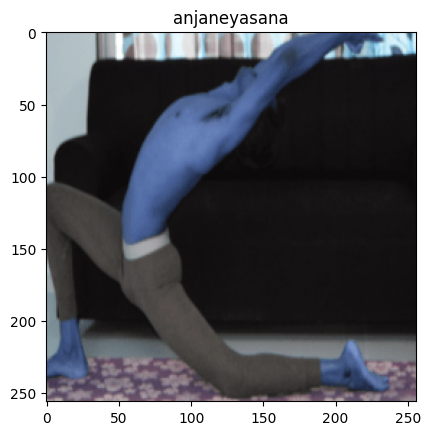

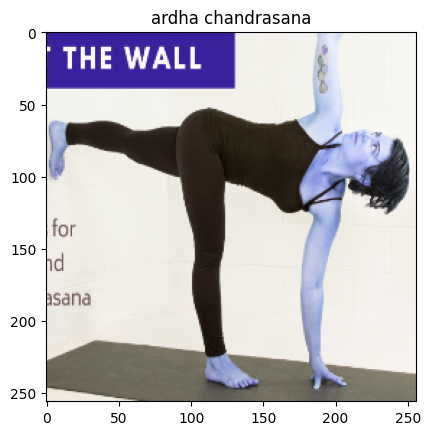

In [ ]:
for i in [300,400]:
    plt.imshow(train_images[i])
    plt.title(labels[train_labels[i]])
    plt.show()

In [ ]:
train_labels = to_categorical(train_labels, 13)

[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]


In [ ]:
X_train,X_test,y_train,y_test = train_test_split(train_images,train_labels,test_size=0.1,shuffle=True)

In [ ]:
model = tf.keras.models.Sequential([
            tf.keras.Input(shape=(256,256,3)),
            tf.keras.layers.RandomFlip("horizontal"),
            tf.keras.layers.RandomRotation(0.1),
            Rescaling(1.0 / 255),
            Conv2D(32,(3,3),activation='relu'),
            MaxPooling2D((2,2)),
            Dropout(0.3),
            Conv2D(64,(3,3),activation='relu'),
            MaxPooling2D((2,2)),
            Dropout(0.3),
            Conv2D(64,(3,3),activation='relu'),
            MaxPooling2D((2,2)),
            Dropout(0.5),
            Flatten(),
            Dense(512,activation='relu'),
            Dense(128,activation='relu'),
            Dense(13,activation='softmax')
])

In [ ]:
model.compile(optimizer='adam',
              loss= tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy']
            )

history = model.fit(X_train, y_train,
          batch_size=32, epochs=25, validation_split=0.2)

Epoch 1/25
17/17 [==============================] - 4s 124ms/step - loss: 1.2385 - accuracy: 0.6011 - val_loss: 1.7308 - val_accuracy: 0.4580
Epoch 2/25
17/17 [==============================] - 2s 113ms/step - loss: 1.1992 - accuracy: 0.5973 - val_loss: 1.7640 - val_accuracy: 0.4733
Epoch 3/25
17/17 [==============================] - 2s 119ms/step - loss: 1.1168 - accuracy: 0.6183 - val_loss: 1.6817 - val_accuracy: 0.5038
Epoch 4/25
17/17 [==============================] - 2s 118ms/step - loss: 1.1489 - accuracy: 0.6298 - val_loss: 1.7465 - val_accuracy: 0.5344
Epoch 5/25
17/17 [==============================] - 2s 111ms/step - loss: 1.1287 - accuracy: 0.6107 - val_loss: 1.7377 - val_accuracy: 0.5115
Epoch 6/25
17/17 [==============================] - 2s 110ms/step - loss: 1.1123 - accuracy: 0.6336 - val_loss: 1.7990 - val_accuracy: 0.4962
Epoch 7/25
17/17 [==============================] - 2s 114ms/step - loss: 1.0638 - accuracy: 0.6603 - val_loss: 1.8066 - val_accuracy: 0.4580
Epoch 

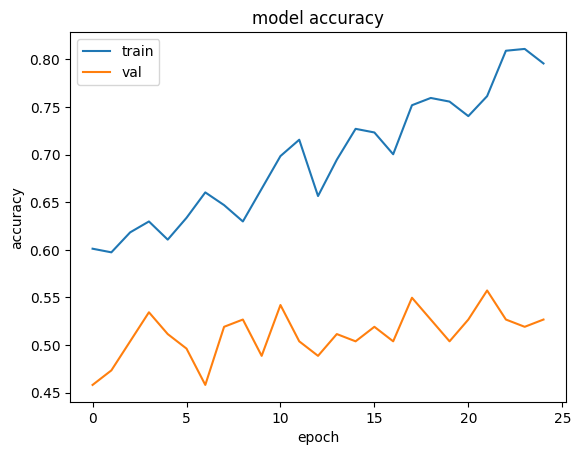

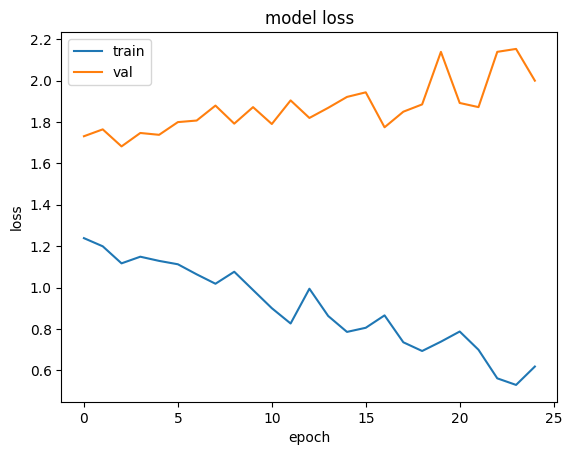

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Transfer Learning - MobileNet

In [ ]:
base_model = tf.keras.applications.mobilenet_v2.MobileNetV2(input_shape=(256, 256, 3),
                                                include_top=False,
                                                weights='imagenet')

9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
base_model.trainable = True

x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(1024,activation='relu')(x)
x = tf.keras.layers.Dense(1024,activation='relu')(x)
x = tf.keras.layers.Dense(512,activation='relu')(x)

outputs = tf.keras.layers.Dense(13,activation='softmax')(x) #len(class_info)
model = tf.keras.Model(inputs = base_model.input, outputs = outputs)

In [ ]:
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 128, 128, 32)         864       ['input_2[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 128, 128, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 128, 128, 32)         0         ['bn_Conv1[0][0]']        

In [ ]:
#Model compile with Adam optimizer, and categorical_crossentropy for the loss
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss = tf.keras.losses.CategoricalCrossentropy(),
              metrics = ['accuracy'])

In [ ]:
#Start training the model, and save the history
history = model.fit(X_train, y_train,
          batch_size=32, epochs=20, validation_split=0.2)

Epoch 1/20
17/17 [==============================] - 32s 294ms/step - loss: 2.4304 - accuracy: 0.1889 - val_loss: 2.5501 - val_accuracy: 0.1145
Epoch 2/20
17/17 [==============================] - 3s 172ms/step - loss: 1.6855 - accuracy: 0.6183 - val_loss: 2.2070 - val_accuracy: 0.3435
Epoch 3/20
17/17 [==============================] - 3s 166ms/step - loss: 0.8117 - accuracy: 0.8302 - val_loss: 1.8474 - val_accuracy: 0.3435
Epoch 4/20
17/17 [==============================] - 3s 177ms/step - loss: 0.2655 - accuracy: 0.9656 - val_loss: 1.4084 - val_accuracy: 0.5038
Epoch 5/20
17/17 [==============================] - 3s 178ms/step - loss: 0.1035 - accuracy: 0.9847 - val_loss: 1.1996 - val_accuracy: 0.5649
Epoch 6/20
17/17 [==============================] - 3s 168ms/step - loss: 0.0289 - accuracy: 1.0000 - val_loss: 1.2660 - val_accuracy: 0.6031
Epoch 7/20
17/17 [==============================] - 3s 173ms/step - loss: 0.0135 - accuracy: 1.0000 - val_loss: 1.1170 - val_accuracy: 0.6183
Epoch

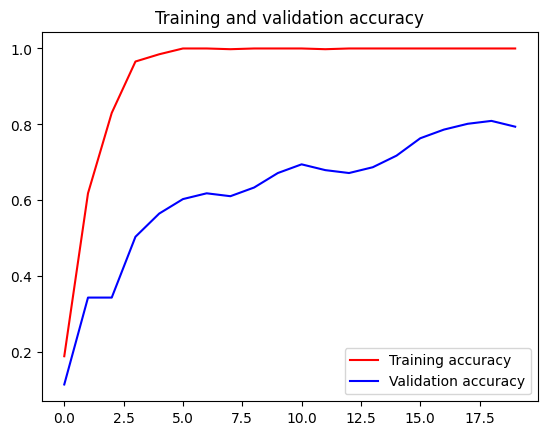

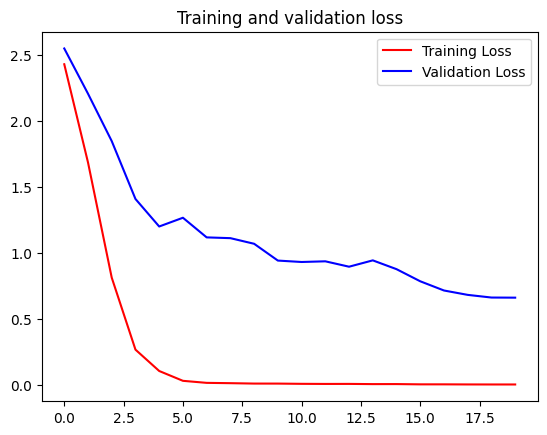

In [ ]:
# Plot the chart for accuracy and loss on both training and validation
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
#Save the model in google colab temporary storage
model_name = 'yoga model.h5'

model.save(model_name)

In [ ]:
#Import files from google.colab library to download model
from google.colab import files
files.download(model_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
imported_model = tf.keras.models.load_model("yoga model.h5")

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open('YouGo.tflite', 'wb') as f:
    f.write(tflite_model)